# Group Project Report: Home Price Regression

### <em>Team Members: Adam Neufeld, Camila Fogaca Dall Bello, Jeremy Davies, Max Makovey

## 1. Introduction

#### 1.1 Background Information

Housing prices vary due to a confluence of factors including location, living space, lot size, to name only a few. The extent to which each factor correlates with house prices is not a cut and dry formula. As such, it can be difficult to predict what price one should sell or offer for a house. This project is built to help figure out these values and the variables that affect housing prices.

#### 1.2 Objective Question

Can we predict home prices based on given input real estate factors such as living space size, lot size, and age of the home?

#### 1.3 Dataset Description

The dataset comprises data for ~1500 house sales in the city of Ames, Iowa from 2006-2010. The response variable in this dataset is the sale price of each home. Additionally, there are ~80 descriptive real estate factors (including living area, # of bedrooms, and lot size) for each observation.

<b>Description of variables of interest:</b>
- SalePrice (response variable): The property's sale price in USD. 
- GrLivArea: Above ground living area in square feet. This variable is significant because it directly correlates with the size of the home. On average, we believe larger homes will sell for higher prices. 
- LotArea: Lot size of property in square feet. This variable is significant because irrespective of the home size, we predict that a larger lot size will correlate with greater sale prices.
- YearBuilt: Year of original construction date. This variable is significant because we can use to it measure the age of the home at its sale date. On average, we expect newer homes to be more valuable.

## 2. Methods & Results

#### 2.1 Reading in data

In [1]:
# Necessary libraries to install:
# - 'gsheet', 'tidyverse', 'cowplot' , 'tidymodels', 'repr', 'GGally', 'gt'
install.packages('gsheet')

# Load in libaries
library(tidyverse)
library(cowplot)
library(tidymodels)
library(gsheet)
library(repr)
library(GGally)
# Suppress table outputs to a manageable # of rows
options(repr.matrix.max.rows = 8)

# Read data from web
data <- gsheet2tbl('docs.google.com/spreadsheets/d/1nNlzfwXkHVk2i946pgf3247KT2vqCDfHZjrBjT-losg/edit?usp=sharing')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.

#### 2.2 Clean and wrangle data

In [2]:
# In this cell, we clean and pre-process the data
# Note: original dataset is already tidy (each obs forms a row, each variable a column, each cell a single measurement)


# Select only the columns (variables) that we evaluated as meaningfully and potentially significant
data_selected <- data %>%
    select(Id, LotArea,YearBuilt, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, YrSold, SalePrice) %>%
    mutate(NumTotalBaths = BsmtFullBath + FullBath + 0.5*(BsmtHalfBath + HalfBath), AgeWhenSold = YrSold-YearBuilt, SalesPrice=SalePrice) %>%
    select(-BsmtFullBath, -BsmtHalfBath, -FullBath, -HalfBath, -YearBuilt, -YrSold, -SalePrice) %>%
    mutate(SalePrice = SalesPrice) %>%
    select(-SalesPrice)

# Inspect clean dataframe
cat("                      Table 2.2.1")
data_selected

                      Table 2.2.1

Id,LotArea,GrLivArea,NumTotalBaths,AgeWhenSold,SalePrice
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8450,1710,3.5,5,208500
2,9600,1262,2.5,31,181500
3,11250,1786,3.5,7,223500
4,9550,1717,2.0,91,140000
⋮,⋮,⋮,⋮,⋮,⋮
1457,13175,2073,3.0,32,210000
1458,9042,2340,2.0,69,266500
1459,9717,1078,2.0,60,142125
1460,9937,1256,2.5,43,147500


In [3]:
#In this cell we split data into a training and testing set
set.seed(1234)

data_selected <- as.data.frame(data_selected)

data_split <- initial_split(data_selected, prop = 3/4, strata = SalePrice)
data_train <- training(data_split)
data_test <- testing(data_split)

# Prepare dfs with only numeric and only non-numeric columns (training dataset ONLY) 
data_train_final <- data_train %>%
    select(-Id)

#### 2.3 Tabular Summary of Data

##### 2.3.1 Summary of numeric variables

In [4]:
# TODO (!!!) Show the number of observations in dataset in a separate table (instead of in cell below)
data_counts <- colSums(!is.na(data_train_final))
data_unique_counts <- summarize_all(data_train_final,n_distinct,na.rm=TRUE)  


observation_counts <- data_counts %>%
    rbind(data_unique_counts)

observation_counts <- cbind(ObservationType = c("Valid Observations","Unique Observations"),observation_counts)


cat("                          Table 2.3.1")
observation_counts
#insert code here

                          Table 2.3.1

ObservationType,LotArea,GrLivArea,NumTotalBaths,AgeWhenSold,SalePrice
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Valid Observations,1097,1097,1097,1097,1097
Unique Observations,831,711,9,117,566


In [5]:
# Calculate descriptive summary stats by variable (training data only)

data_max <- summarize_all(data_train_final,max, na.rm = TRUE)  
data_min <- summarize_all(data_train_final,min, na.rm = TRUE)   
data_mean <- summarize_all(data_train_final,mean, na.rm = TRUE)   




# Bind summary stats into one summary table
data_observations <-  data_max %>%
    rbind(data_min) %>%
    rbind(data_mean) %>%
    signif(4)

data_observations <- cbind(ObservationType = c("Maximum value","Minimum value", "Mean value"), data_observations)
cat("                          Table 2.3.2")
data_observations

                          Table 2.3.2

ObservationType,LotArea,GrLivArea,NumTotalBaths,AgeWhenSold,SalePrice
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Maximum value,215200,4676,6.000,135.00,745000
Minimum value,1300,334,1.000,0.00,35310
Mean value,10550,1513,2.214,36.45,180700


#### 2.4 Visual Summary of Data

##### 2.4.1 Scatterplot grid for quick scan of correlations

                                                                 Figure 2.4.1

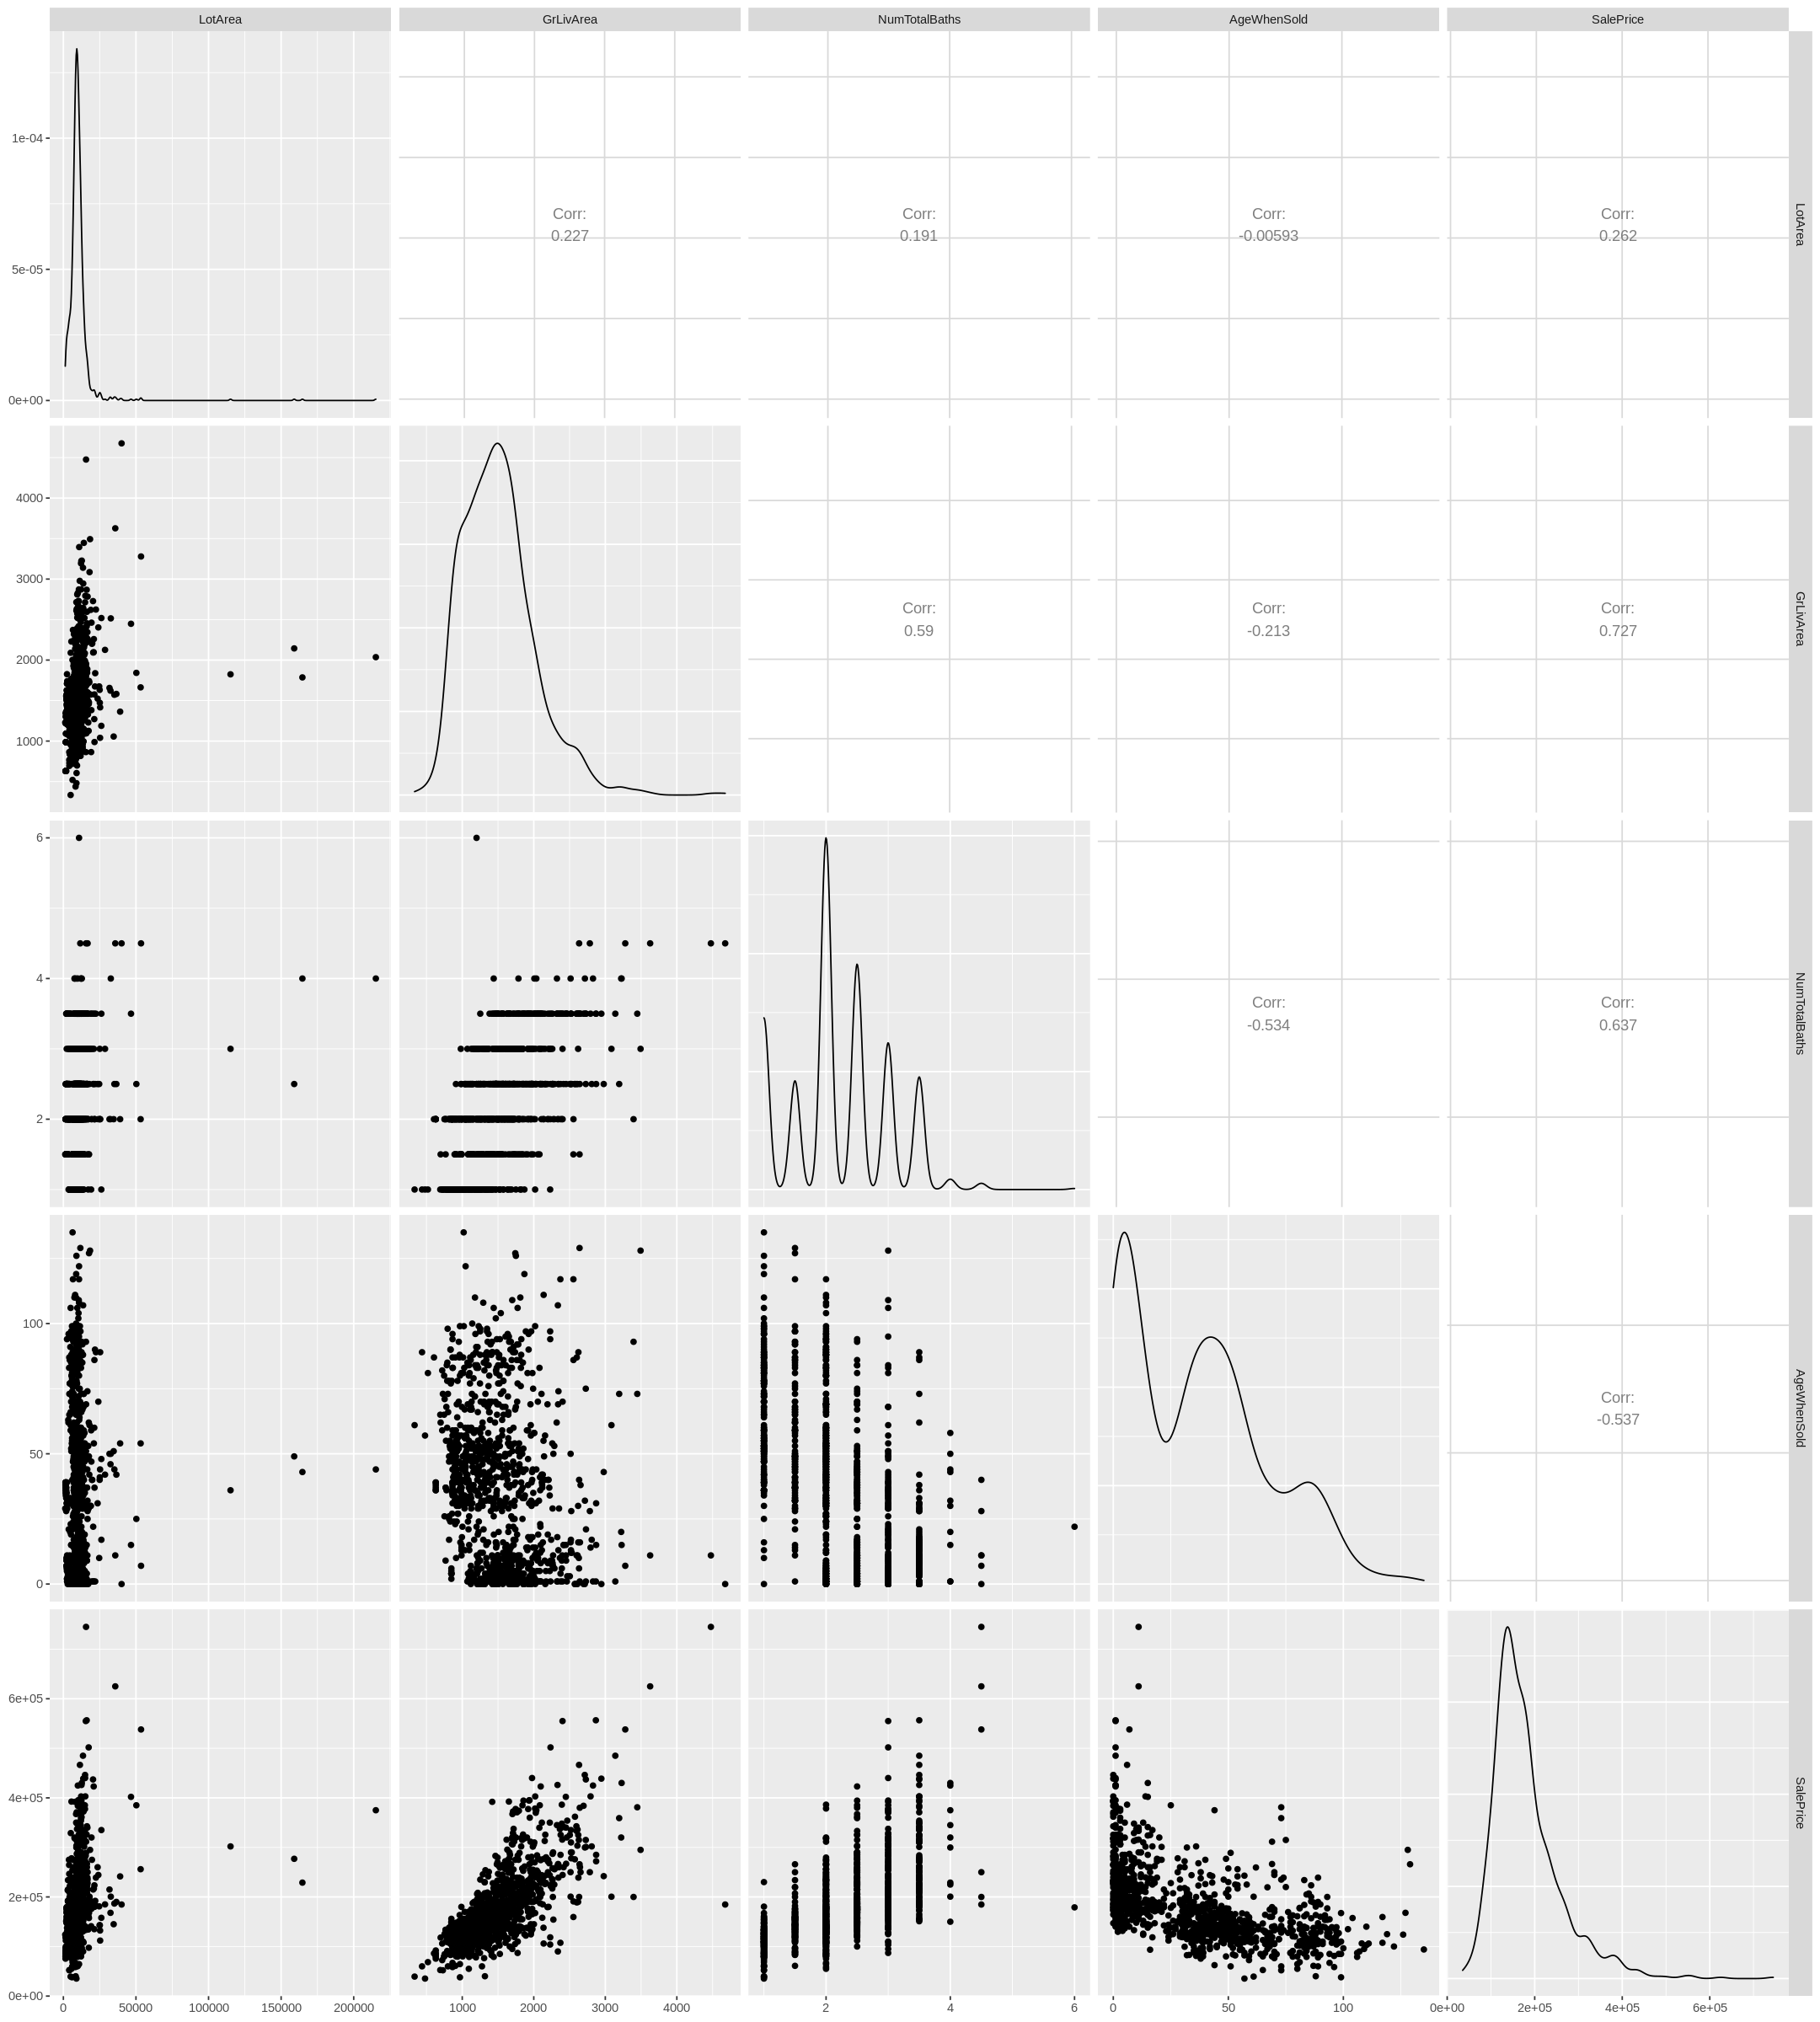

In [6]:
#set plot output size
options(repr.plot.width = 18, repr.plot.height = 20)

cat("                                                                 Figure 2.4.1")
ggpairs(data_train_final)

##### 2.4.2 Sale price by living area size and year built

In [7]:
# set plot output size
options(repr.plot.width = 8, repr.plot.height = 8)

# create scatterplot
#exterior_plot<- ggplot( data_train, aes(x=GrLivArea , y=SalePrice, color= YearBuilt) ) + 
#        geom_point(alpha = 0.5) +
#        labs(x = "Above Ground Living Area (sf)", y = "Sale Price ($)", colour = "Year Built") +
#        ggtitle("Sale Price by Living Area and Year Built") +
#        theme(text = element_text(size = 16))
        
#exterior_plot

#### 2.5 Data analysis

##### 2.5.1. Variable selection for the linear regression model

   To choose our variables, we aimed to choose the ones with the most influence in price. 
In order to achieve that, we analyzied different research that focused on determinants of house prices. 
It was found that locality, living area, lot size and age were the most influential factors (Zietz, J et.al, 2018; Aminah Md Yusof, 2012; Johansson, Anna,2017). Furthermore, we used ggpairs to determine the correlation between the variables and sales price. It was found that the number of bathrooms had strong correlation with sales price (0.637).
    However, due to the complexity of using a categorical variable, such as location, to perform a linear regression model, we opted to exclude location from our options and stick to the numerical variables only: ground living area, lot size, age when sold and number of bathrooms. Still, Despite what literature said, after visualizing our variables correlation in ggpairs, it came to our attention that lot size and sales price had very little correlation (0.262). In addition, we noted that the number of bathrooms was highly correlated with the living area and, therefore, it would not make much sense to use both as predictive variables. Due to this, we decided to remove number of bathrooms and lot size and use only two predictive variables for our model: Ground Living Area and Age when sold.

##### 2.5.2 Fit Linear Regression Model

Fit a linear regression model using tidymodels with (Ames) data_train using [THE VARIABLES SELECTED JUST ABOVE]. - We will create a model specification, recipe, and pass that into a workflow, then create the model fit.

In [8]:
# initialize model spec
lm_spec <- linear_reg() %>%
set_engine("lm") %>%
set_mode("regression")

# prepare recipe
homes_recipe <- recipe(SalePrice ~ GrLivArea + AgeWhenSold, data = data_train_final)

# construct workflow
homes_fit <- workflow() %>%
    add_recipe(homes_recipe) %>%
    add_model(lm_spec) %>%
    fit(data = data_train_final)

#(!!!) I don't know if we should add a figure name for this
homes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    GrLivArea  AgeWhenSold  
   69782.29        98.44     -1043.13  


(!!! TODO) write down equation for linear model and explain interpretation in English (e.g. holding all other variables constant, a 1 unit increase in ...)
The equation of our model is (ADD EQUATION). This means that our model expects houses to depreciate at a rate of 1043.13 dollars per year as well as gain 98.44 dollars per above ground sqaure foot of living area.

##### 2.5.!!! Evaluation of linear regression model

To evaluate how our model might do at predicting on unseen data, we are calculating its Root Mean Squared Prediction Error (RMSPE) on the test data. RMSPE effectively measures how closely our model predicts values of the sale price relative to the actual sale prices of the observations. If our model is a good predictor, we want to see a smaller RMSPE.

In [14]:
# Compute RMSPE  (!!! TODO)
homes_rmspe <- homes_fit %>%
    predict(data_test) %>%
    bind_cols(data_test) %>%
    metrics(truth = SalePrice, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    pull(.estimate) %>%
    signif(5)

mean_test_sale_price <- data_test %>%
    summarize(mean = mean(SalePrice)) %>%
    pull() %>%
    signif(6)

cat("Root Mean Squared Prediction Error: ", homes_rmspe)
cat("\nMean Sale Price of Test Data: ", mean_test_sale_price)

Root Mean Squared Prediction Error:  54091
Mean Sale Price of Test Data:  181724

To put our RMSPE into perspective we calucated the average sale price (181724) of the testing data and compared it to the RMSPE (54091). This showed that on average our predictions were around 30% off of the actual value $(54000/182000  = 0.3)$. This result is a little high and could be due to multiple factors including the fact that our model was unable to include location as a factor which was cited by multiple articles as being important (ADD CITATION).

#### 2.6 Visualization of the analysis

To visualize our results we made two graphs plotting each predictor variable against the Sale Price. We also added a line in each graph showing what our model would predict given the value of that variable alone.

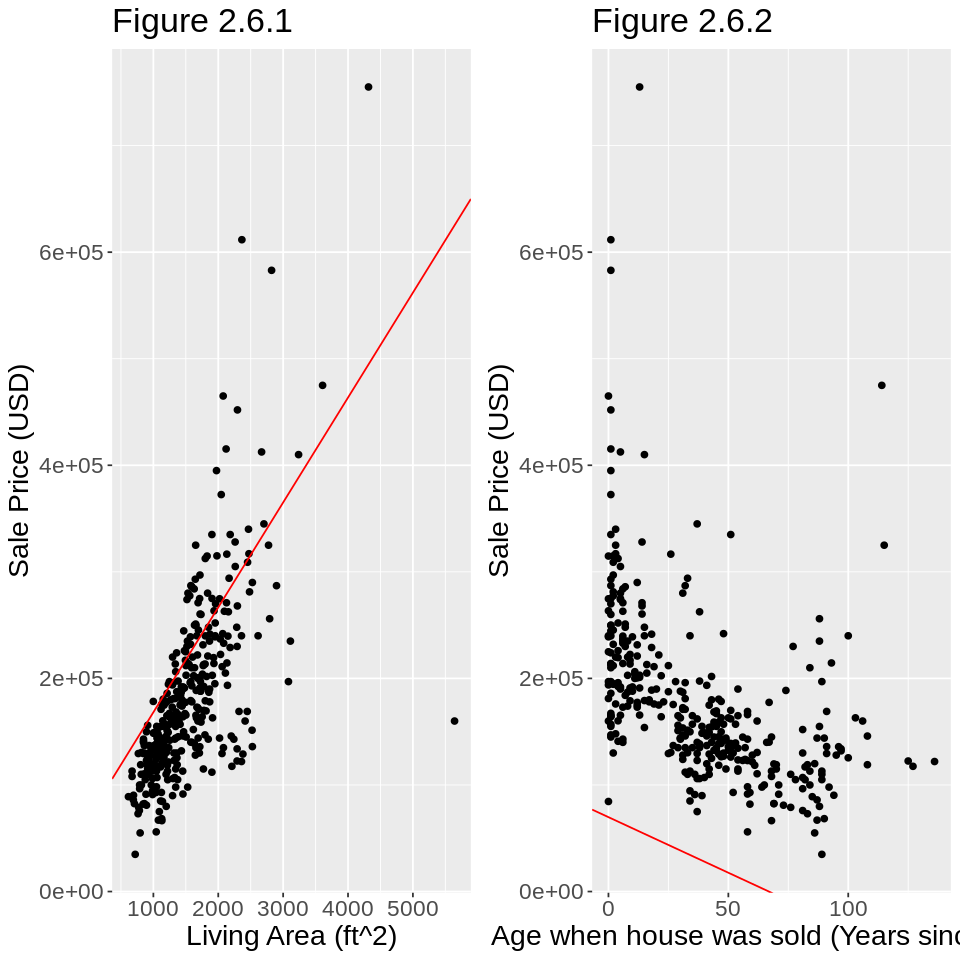

In [10]:
#col_names <- c("Lot Area (ft^2)", "Living Area (ft^2)", "Number of Total Baths", "Age when house was sold (Years since built)")

#Remove SalePrice and Id from Numeric data frame
#data_without_price <- data_train_final %>%
#    select(-SalePrice)

plot_list <- list()

liv_area_plot <- data_test %>% 
    ggplot(aes(x = GrLivArea, y = SalePrice)) +
    geom_point() +
    geom_abline(slope = 98.44, intercept = 69782.29,color = "Red") +
    labs(x = "Living Area (ft^2)", y="Sale Price (USD)",title = "Figure 2.6.1") +
    theme(text = element_text(size=17))

house_age_plot <- data_test %>%
    ggplot(aes(x=AgeWhenSold,y=SalePrice)) +
    geom_point() +
    geom_abline(slope = -1043.13, intercept = 69782.29,color = "Red") +
    labs(x = "Age when house was sold (Years since built)", y="Sale Price (USD)", title= "Figure 2.6.2") +
    theme(text = element_text(size=17))


plot_list[[1]] <- liv_area_plot
plot_list[[2]] <- house_age_plot

#Plot all Numeric variables against SalePrice and storing them in a list
#for (i in 1:length(names(data_without_price))){
#    new_data <- cbind(x_var = data_without_price[i],y_var = data_train_final$SalePrice)
#    new_data <- rename(new_data, x_var = 1)
#    plot <- ggplot(new_data, aes(y=y_var, x=x_var)) +
#        geom_point(alpha = 0.7) +
#        labs(y = "Sale Price (USD)", x = col_names[i]) + theme(text = element_text(size=17))
#    plot_list[[i]] <- plot
#}

#cat("                               Figure 2.6.1")
plot_grid(plotlist = plot_list)



!!! (TO DO) Short discussion on visual analysis

## 3. Discussion

#### 3.1 Summary of findings

After completing our model, we found that our initial goal to determine whether or not it was possible to predict home prices based on given input real estate factors, was indeed possible. We were able to create a linear regression model that predicts house prices based on real estate factors such as ground living area and age of the house when sold. Furthermore, it was found that our linear model had a intercept coefficient of 69782.29, a Ground Living Area with a 98.44 multiplier and a multiplier of  -1043.13 to Age when Sold. We also found that our root mean squared prediction error was 54091, which, compared to the mean home sale price of 181,000 dollars (Table 2.3.2), means that our predictions were off by about 30%. 

#### 3.2 Results against expectations

Our expectations of creating a linear regression model were successfull, however, we did not expect our RMSPE to be as high as it is (54091). We came to the conclusion that our RMSPE is high due to the fact that we did not account for location of the house,  which was mentioned to be a large factor in articles. Furthermore, We did not expect house age to have such a large impact on price (-1043.13 dollars per year).

#### 3.3 Potential impact

In our view, there are two notable potential impacts from this work: 
1. Real estate agents could garner a better understanding into the drivers of home selling prices.
2. We can take key valuation insights with us in our personal life for when we one day purchase homes of our own.

#### 3.4 Future questions

Our analysis on factors contributing to the selling price of a home could spark future questions, including:

- How has the weight of each factor that contributes to the selling price changed over time? Is there a pattern to this change?
- Do the factors contributing most to selling prices in Ames, Iowa (our dataset) also work for other regions?
- How good would our model be if we used location as a a predictive factor?

## 4. References

#### 4.1 Relevant Literature Citations

Md Yusof, Aminah & Ismail, Syuhaida. (2012). Multiple Regressions in Analysing House Price Variations. Communications of the IBIMA. 2012. 1-9. 10.5171/2012.383101. 

Zietz, J., Zietz, E. N., & Sirmans, G. S. (2008). Determinants of house prices: A quantile regression approach. Journal of Real Estate Finance and Economics, 37(4), 317-333. doi:http://dx.doi.org.ezproxy.library.ubc.ca/10.1007/s11146-007-9053-7

Johansson, Anna. (2017). 6 Factors That Influence A Home's Value. https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/ 
(fix this last citation)

#### 4.2 Dataset Citation

(!!! TODO). Cite dataset